In [2]:
import os
import cv2
import shutil
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.preprocessing.image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Conv2D, MaxPool2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from sklearn.preprocessing import LabelEncoder

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Set the path to the dataset
dataset_path = "/content/drive/MyDrive/dataset/bijikopi"
os.listdir(dataset_path)

Mounted at /content/drive


['Grade 3', 'Grade 2', 'Grade 1']

In [4]:
print('Grade 1 :',len(os.listdir("/content/drive/MyDrive/dataset/bijikopi/Grade 1")))
print('Grade 2 :',len(os.listdir("/content/drive/MyDrive/dataset/bijikopi/Grade 2")))
print('Grade 3 :',len(os.listdir("/content/drive/MyDrive/dataset/bijikopi/Grade 3")))

Grade 1 : 1000
Grade 2 : 1000
Grade 3 : 1000


In [5]:
# Load the dataset
data = []
labels = []

# Iterate through the dataset path and load the images
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 150))
        data.append(image)
        labels.append(category)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [6]:
# Perform label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

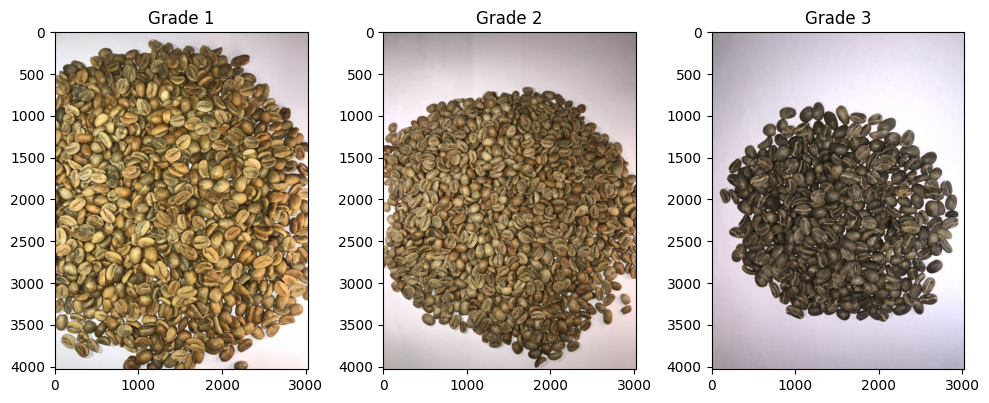

In [7]:
# Get a list of images in each grade folder
grade1_images = os.listdir(os.path.join(dataset_path, "Grade 1"))
grade2_images = os.listdir(os.path.join(dataset_path, "Grade 2"))
grade3_images = os.listdir(os.path.join(dataset_path, "Grade 3"))

# Choose a random sample from each grade
sample_grade1 = random.choice(grade1_images)
sample_grade2 = random.choice(grade2_images)
sample_grade3 = random.choice(grade3_images)

# Load and display the sample images
sample1_path = os.path.join(dataset_path, "Grade 1", sample_grade1)
sample2_path = os.path.join(dataset_path, "Grade 2", sample_grade2)
sample3_path = os.path.join(dataset_path, "Grade 3", sample_grade3)

sample1_img = cv2.imread(sample1_path)
sample2_img = cv2.imread(sample2_path)
sample3_img = cv2.imread(sample3_path)

# Convert BGR to RGB
sample1_img = cv2.cvtColor(sample1_img, cv2.COLOR_BGR2RGB)
sample2_img = cv2.cvtColor(sample2_img, cv2.COLOR_BGR2RGB)
sample3_img = cv2.cvtColor(sample3_img, cv2.COLOR_BGR2RGB)

# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(sample1_img)
plt.title("Grade 1")

plt.subplot(1, 3, 2)
plt.imshow(sample2_img)
plt.title("Grade 2")

plt.subplot(1, 3, 3)
plt.imshow(sample3_img)
plt.title("Grade 3")

plt.tight_layout()
plt.show()

In [8]:
# Perform data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1,  # Random vertical shift
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    validation_split=0.1  # Splitting the dataset into train and validation sets
)

In [9]:
# Split the dataset into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

In [10]:
# Apply data augmentation to the training set
train_generator = datagen.flow(train_data, train_labels, batch_size=32, subset='training')

# Apply data augmentation to the validation set
val_generator = datagen.flow(val_data, val_labels, batch_size=32, subset='validation')

In [11]:
# Get the class names
class_names = label_encoder.classes_

# Display the class names
print("Class Names:", class_names)

Class Names: ['Grade 1' 'Grade 2' 'Grade 3']


In [12]:
# Split the validation set into validation and test sets
val_data, test_data, val_labels, test_labels = train_test_split(
    val_data, val_labels, test_size=0.25, stratify=val_labels, random_state=42
)

In [13]:
# Normalize the image data
train_data = train_data.astype('float32') / 255.0
val_data = val_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# Print the shape of each dataset
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (2400, 150, 150, 3)
Validation data shape: (450, 150, 150, 3)
Test data shape: (150, 150, 150, 3)
Train labels shape: (2400,)
Validation labels shape: (450,)
Test labels shape: (150,)


In [14]:
print('Train :', len(train_data))
print('Validation :', len(val_data))
print('Test :', len(test_data))

Train : 2400
Validation : 450
Test : 150


In [104]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    #Conv2D(128, (3, 3), activation='relu'),
    #MaxPool2D((2, 2)),
    #Conv2D(128, (3, 3), activation='relu'),
    #MaxPool2D((2, 2)),
    Flatten(),
    #Dense(128, activation='relu'),
    #Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    verbose = 1,
                    epochs=20)

Epoch 1/20
68/68 [==============================] - 103s 1s/step - loss: 18.3707 - accuracy: 0.6051 - val_loss: 2.4813 - val_accuracy: 0.7833
Epoch 2/20
68/68 [==============================] - 103s 2s/step - loss: 2.7339 - accuracy: 0.7542 - val_loss: 4.3914 - val_accuracy: 0.7167
Epoch 3/20
68/68 [==============================] - 105s 2s/step - loss: 2.5960 - accuracy: 0.7856 - val_loss: 0.8139 - val_accuracy: 0.8833
Epoch 4/20
68/68 [==============================] - 97s 1s/step - loss: 1.3241 - accuracy: 0.8523 - val_loss: 0.6675 - val_accuracy: 0.8833
Epoch 5/20
68/68 [==============================] - 95s 1s/step - loss: 1.1609 - accuracy: 0.8653 - val_loss: 0.8307 - val_accuracy: 0.9000
Epoch 6/20
68/68 [==============================] - 94s 1s/step - loss: 1.2487 - accuracy: 0.8597 - val_loss: 0.4634 - val_accuracy: 0.9000
Epoch 7/20
68/68 [==============================] - 97s 1s/step - loss: 0.6718 - accuracy: 0.9074 - val_loss: 0.9355 - val_accuracy: 0.8833
Epoch 8/20
68/68

In [106]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 82944)             0         
                                                                 
 dense_11 (Dense)            (None, 3)                

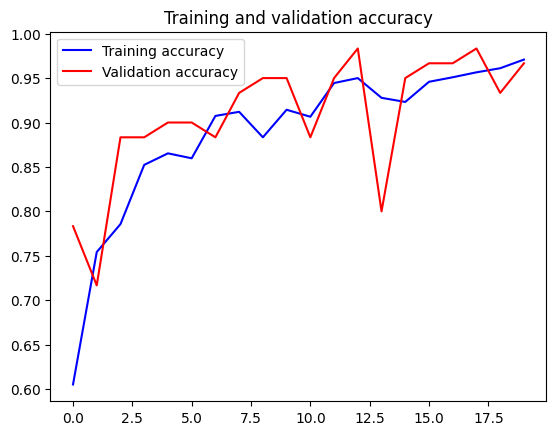

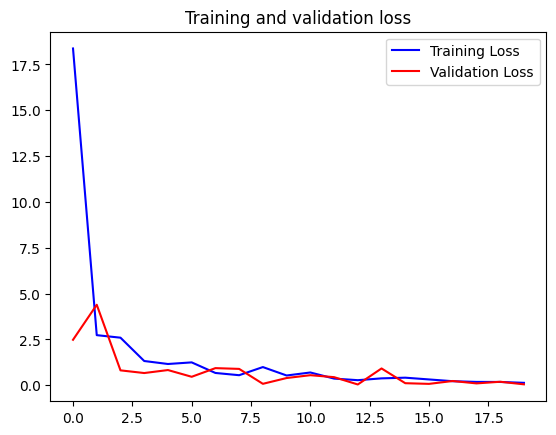

In [107]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

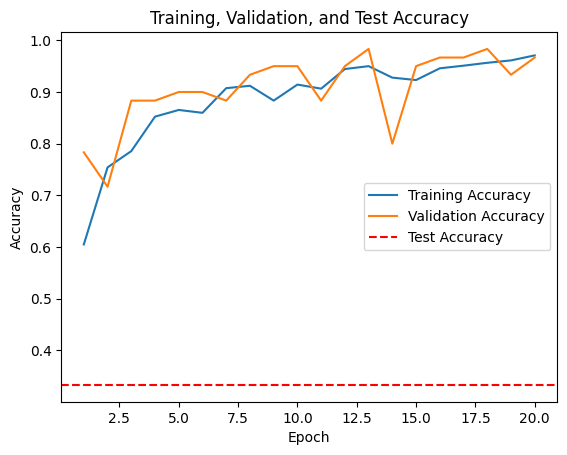

In [109]:
# Get the training and validation accuracy from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy curves
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.axhline(test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

In [117]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Get the train accuracy
train_loss, train_accuracy = model.evaluate(train_data, train_labels)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Get the val accuracy
val_loss, val_accuracy = model.evaluate(val_data, val_labels)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)


5/5 [==============================] - 1s 273ms/step - loss: 1.0174 - accuracy: 0.5533
Test Loss: 1.0174460411071777
Test Accuracy: 0.5533333420753479
75/75 [==============================] - 31s 416ms/step - loss: 1.0123 - accuracy: 0.6104
Train Loss: 1.0123294591903687
Train Accuracy: 0.6104166507720947
15/15 [==============================] - 4s 272ms/step - loss: 1.0151 - accuracy: 0.5889
Val Loss: 1.0150964260101318
Val Accuracy: 0.5888888835906982


In [111]:
model.save('modelv2.h5')
model.save('modelv2')
!zip -r 'modelv2.zip' 'modelv2'

updating: modelv2/ (stored 0%)
updating: modelv2/fingerprint.pb (stored 0%)
updating: modelv2/keras_metadata.pb (deflated 89%)
updating: modelv2/saved_model.pb (deflated 88%)
updating: modelv2/variables/ (stored 0%)
updating: modelv2/variables/variables.index (deflated 60%)
updating: modelv2/variables/variables.data-00000-of-00001 (deflated 9%)
updating: modelv2/assets/ (stored 0%)


In [112]:
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model('modelv2')

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./modelv2.tflite')
tflite_model_file.write_bytes(tflite_model)

275080

In [113]:
# Make predictions on the test data
test_predictions = model.predict(test_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Decode the predicted labels using the label encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# Compare the predicted classes with the true classes
for i in range(len(test_labels)):
    print("True Label: ", label_encoder.inverse_transform([test_labels[i]]))
    print("Predicted Label: ", predicted_classes[i])
    print("------------------------------------")

5/5 [==============================] - 1s 282ms/step
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 1']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 3
----------------

15/15 [==============================] - 5s 323ms/step


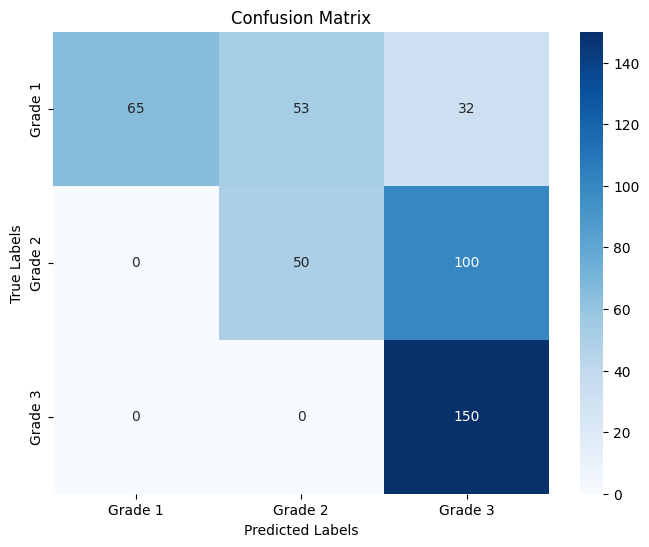

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions on the validation set
val_predictions = model.predict(val_data)

# Convert the predicted probabilities to class labels
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(val_labels, val_predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

5/5 [==============================] - 2s 368ms/step


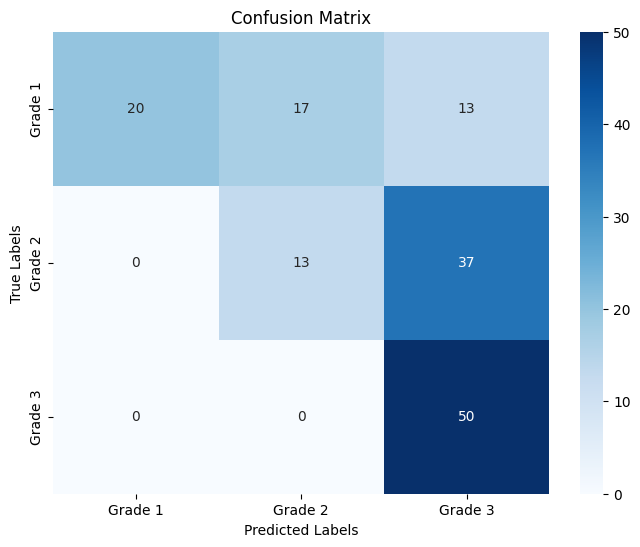

In [115]:
# Generate predictions on the test set
test_predictions = model.predict(test_data)

# Convert the predicted probabilities to class labels
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(test_labels, test_predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [116]:
from sklearn.metrics import classification_report

# Make predictions on the test data
test_predictions = model.predict(test_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Decode the predicted labels using the label encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# Generate the classification report
report = classification_report(test_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)


5/5 [==============================] - 1s 281ms/step
Classification Report:
              precision    recall  f1-score   support

     Grade 1       1.00      0.40      0.57        50
     Grade 2       0.43      0.26      0.33        50
     Grade 3       0.50      1.00      0.67        50

    accuracy                           0.55       150
   macro avg       0.64      0.55      0.52       150
weighted avg       0.64      0.55      0.52       150



**MOBILENET**

In [52]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model without the top classifier
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [53]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 164,355
Non-

In [55]:
# Train the model
history_v2 = mobilenet_model.fit(train_data, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_data, val_labels))

Epoch 1/10
75/75 [==============================] - 70s 819ms/step - loss: 0.6883 - accuracy: 0.7254 - val_loss: 0.2794 - val_accuracy: 0.9644
Epoch 2/10
75/75 [==============================] - 54s 718ms/step - loss: 0.2340 - accuracy: 0.9492 - val_loss: 0.1345 - val_accuracy: 0.9867
Epoch 3/10
75/75 [==============================] - 54s 727ms/step - loss: 0.1299 - accuracy: 0.9792 - val_loss: 0.0832 - val_accuracy: 0.9933
Epoch 4/10
75/75 [==============================] - 54s 713ms/step - loss: 0.0840 - accuracy: 0.9908 - val_loss: 0.0586 - val_accuracy: 0.9933
Epoch 5/10
75/75 [==============================] - 53s 716ms/step - loss: 0.0633 - accuracy: 0.9887 - val_loss: 0.0455 - val_accuracy: 0.9933
Epoch 6/10
75/75 [==============================] - 53s 711ms/step - loss: 0.0478 - accuracy: 0.9942 - val_loss: 0.0374 - val_accuracy: 0.9956
Epoch 7/10
75/75 [==============================] - 56s 741ms/step - loss: 0.0390 - accuracy: 0.9962 - val_loss: 0.0316 - val_accuracy: 0.9956

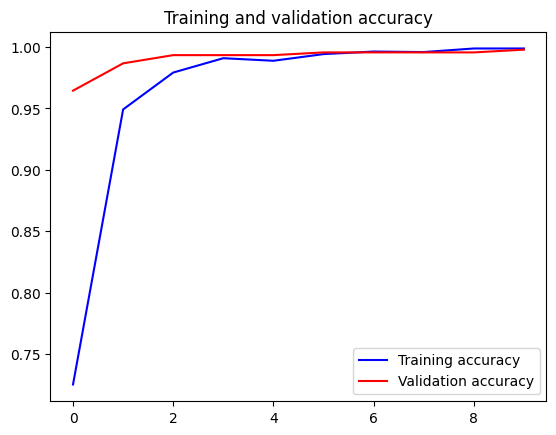

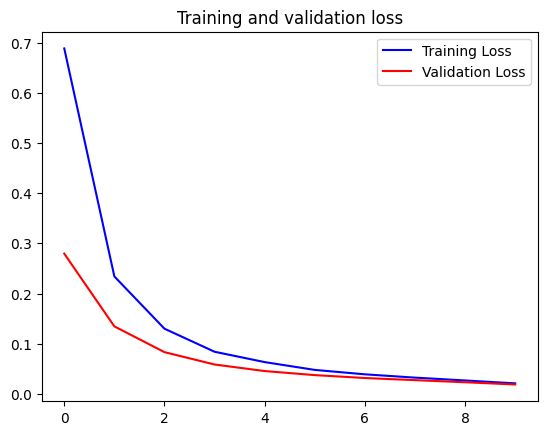

In [56]:
import matplotlib.pyplot as plt

acc = history_v2.history['accuracy']
val_acc = history_v2.history['val_accuracy']
loss = history_v2.history['loss']
val_loss = history_v2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

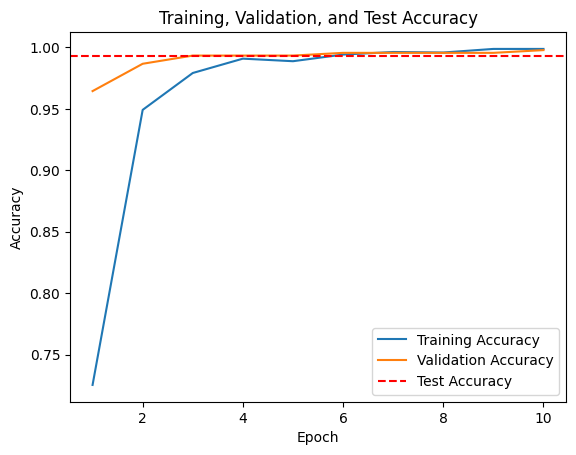

In [62]:
# Get the training and validation accuracy from the history object
train_accuracy = history_v2.history['accuracy']
val_accuracy = history_v2.history['val_accuracy']

# Plot the accuracy curves
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.axhline(test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

In [58]:
# Evaluate the model on the test set
test_loss, test_accuracy = mobilenet_model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Get the train accuracy
train_loss, train_accuracy = mobilenet_model.evaluate(train_data, train_labels)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Get the val accuracy
val_loss, val_accuracy = mobilenet_model.evaluate(val_data, val_labels)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

5/5 [==============================] - 2s 457ms/step - loss: 0.0210 - accuracy: 0.9933
Test Loss: 0.020994029939174652
Test Accuracy: 0.9933333396911621
75/75 [==============================] - 47s 628ms/step - loss: 0.0141 - accuracy: 0.9996
Train Loss: 0.0140748405829072
Train Accuracy: 0.9995833039283752
15/15 [==============================] - 8s 506ms/step - loss: 0.0187 - accuracy: 0.9978
Val Loss: 0.018747102469205856
Val Accuracy: 0.9977777600288391


In [59]:
mobilenet_model.save('mobilenet_model.h5')
mobilenet_model.save('mobilenet_model')
!zip -r 'mobilenet_model.zip' 'mobilenet_model'

  adding: mobilenet_model/ (stored 0%)
  adding: mobilenet_model/fingerprint.pb (stored 0%)
  adding: mobilenet_model/keras_metadata.pb (deflated 96%)
  adding: mobilenet_model/saved_model.pb (deflated 91%)
  adding: mobilenet_model/variables/ (stored 0%)
  adding: mobilenet_model/variables/variables.index (deflated 76%)
  adding: mobilenet_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: mobilenet_model/assets/ (stored 0%)


In [60]:
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model('mobilenet_model')

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./mobilenet_model.tflite')
tflite_model_file.write_bytes(tflite_model)

2675544

In [61]:
# Make predictions on the test data
test_predictions = mobilenet_model.predict(test_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Decode the predicted labels using the label encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# Compare the predicted classes with the true classes
for i in range(len(test_labels)):
    print("True Label: ", label_encoder.inverse_transform([test_labels[i]]))
    print("Predicted Label: ", predicted_classes[i])
    print("------------------------------------")

5/5 [==============================] - 4s 537ms/step
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 1']
Predicted Label:  Grade 1
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
----------------

5/5 [==============================] - 5s 917ms/step


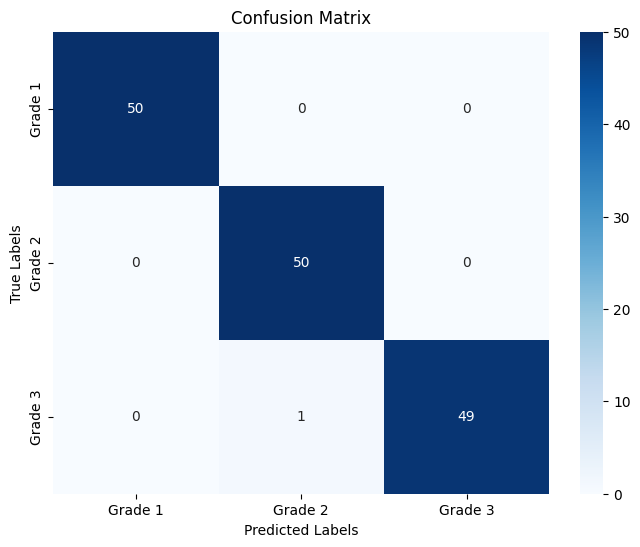

In [64]:
# Generate predictions on the test set
test_predictions = mobilenet_model.predict(test_data)

# Convert the predicted probabilities to class labels
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(test_labels, test_predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

5/5 [==============================] - 5s 910ms/step


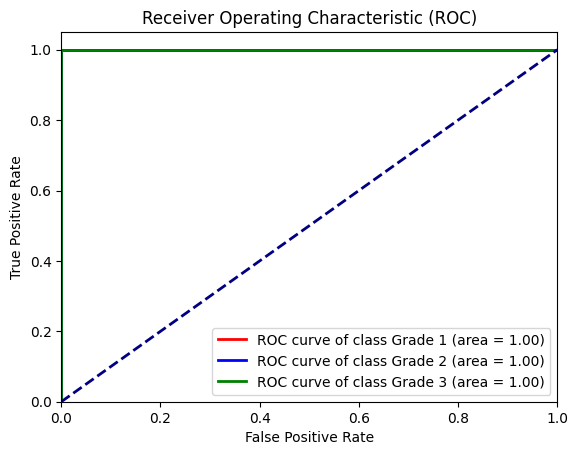

Macro-average ROC AUC: 1.0


In [65]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Convert labels to binary format
binary_labels = label_binarize(test_labels, classes=np.arange(len(class_names)))

# Compute the predicted probabilities for each class
class_probabilities = mobilenet_model.predict(test_data)

# Compute the macro-average ROC AUC score
roc_auc = roc_auc_score(binary_labels, class_probabilities, average='macro')

# Plot the ROC curve for each class
plt.figure()
lw = 2
colors = ['red', 'blue', 'green']  # Add more colors if there are more classes
for i, color in zip(range(len(class_names)), colors):
    fpr, tpr, _ = roc_curve(binary_labels[:, i], class_probabilities[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc_class))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print the macro-average ROC AUC score
print("Macro-average ROC AUC:", roc_auc)

In [82]:
from sklearn.metrics import classification_report

# Make predictions on the test data
test_predictions = mobilenet_model.predict(test_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Decode the predicted labels using the label encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# Generate the classification report
report = classification_report(test_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)

5/5 [==============================] - 4s 747ms/step
Classification Report:
              precision    recall  f1-score   support

     Grade 1       1.00      1.00      1.00        50
     Grade 2       0.98      1.00      0.99        50
     Grade 3       1.00      0.98      0.99        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



**RESTNET**

In [67]:
import tensorflow_hub as hub
import tensorflow as tf
restnet_v1 = "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5"
restnet_v1_layers = hub.KerasLayer(restnet_v1, input_shape=(150,150,3))
restnet_v1_layers.trainable = False

restnet_v1_model = tf.keras.Sequential([
    restnet_v1_layers,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    # tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')
])

In [68]:
restnet_v1_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [69]:
restnet_v1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              25612201  
                                                                 
 dropout_2 (Dropout)         (None, 1001)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               256512    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 25,901,996
Trainable params: 289,795
Non-trainable params: 25,612,201
_________________________________________________________________


In [70]:
hist = restnet_v1_model.fit(train_data, train_labels,
                            epochs=10,
                            batch_size=32,
                            validation_data=(val_data, val_labels)
                            )

Epoch 1/10
75/75 [==============================] - 256s 3s/step - loss: 0.7478 - accuracy: 0.6975 - val_loss: 0.2848 - val_accuracy: 0.8933
Epoch 2/10
75/75 [==============================] - 224s 3s/step - loss: 0.3058 - accuracy: 0.8825 - val_loss: 0.1288 - val_accuracy: 0.9578
Epoch 3/10
75/75 [==============================] - 224s 3s/step - loss: 0.1841 - accuracy: 0.9317 - val_loss: 0.0926 - val_accuracy: 0.9711
Epoch 4/10
75/75 [==============================] - 224s 3s/step - loss: 0.1441 - accuracy: 0.9483 - val_loss: 0.0600 - val_accuracy: 0.9800
Epoch 5/10
75/75 [==============================] - 224s 3s/step - loss: 0.1008 - accuracy: 0.9658 - val_loss: 0.0425 - val_accuracy: 0.9867
Epoch 6/10
75/75 [==============================] - 218s 3s/step - loss: 0.0930 - accuracy: 0.9683 - val_loss: 0.0425 - val_accuracy: 0.9844
Epoch 7/10
75/75 [==============================] - 224s 3s/step - loss: 0.0701 - accuracy: 0.9771 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 8/10
75

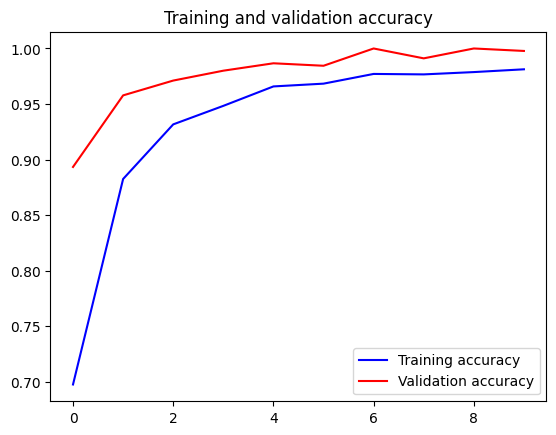

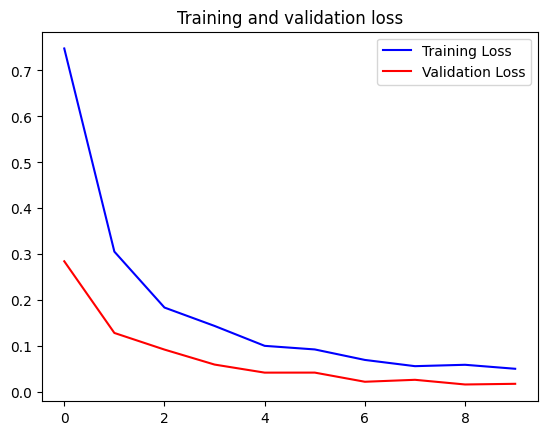

In [71]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

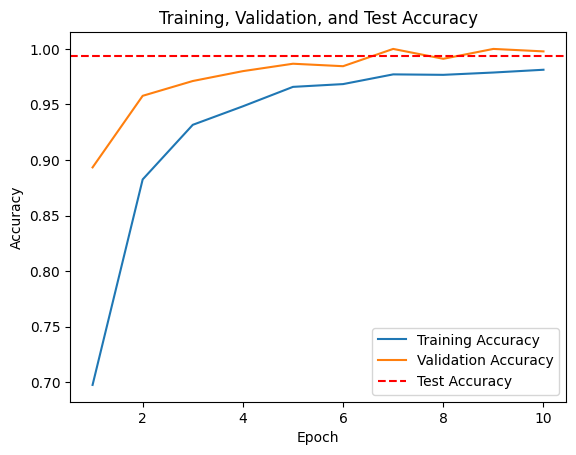

In [72]:
# Get the training and validation accuracy from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Plot the accuracy curves
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.axhline(test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

In [73]:
# Evaluate the model on the test set
test_loss, test_accuracy = restnet_v1_model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Get the train accuracy
train_loss, train_accuracy = restnet_v1_model.evaluate(train_data, train_labels)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Get the val accuracy
val_loss, val_accuracy = restnet_v1_model.evaluate(val_data, val_labels)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

5/5 [==============================] - 12s 2s/step - loss: 0.0234 - accuracy: 0.9933
Test Loss: 0.02343006432056427
Test Accuracy: 0.9933333396911621
75/75 [==============================] - 183s 2s/step - loss: 0.0134 - accuracy: 0.9975
Train Loss: 0.01341120433062315
Train Accuracy: 0.9975000023841858
15/15 [==============================] - 38s 2s/step - loss: 0.0182 - accuracy: 0.9978
Val Loss: 0.018165012821555138
Val Accuracy: 0.9977777600288391


In [74]:
model.save('restnet_v1_model.h5')
model.save('restnet_v1_model')
!zip -r 'restnet_v1_model.zip' 'restnet_v1_model'

  adding: restnet_v1_model/ (stored 0%)
  adding: restnet_v1_model/fingerprint.pb (stored 0%)
  adding: restnet_v1_model/keras_metadata.pb (deflated 89%)
  adding: restnet_v1_model/saved_model.pb (deflated 88%)
  adding: restnet_v1_model/variables/ (stored 0%)
  adding: restnet_v1_model/variables/variables.index (deflated 60%)
  adding: restnet_v1_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: restnet_v1_model/assets/ (stored 0%)


In [75]:
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model('restnet_v1_model')

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./restnet_v1_model.tflite')
tflite_model_file.write_bytes(tflite_model)

275056

In [76]:
# Make predictions on the test data
test_predictions = restnet_v1_model.predict(test_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Decode the predicted labels using the label encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# Compare the predicted classes with the true classes
for i in range(len(test_labels)):
    print("True Label: ", label_encoder.inverse_transform([test_labels[i]]))
    print("Predicted Label: ", predicted_classes[i])
    print("------------------------------------")

5/5 [==============================] - 13s 2s/step
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 1']
Predicted Label:  Grade 1
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------------------------
True Label:  ['Grade 2']
Predicted Label:  Grade 2
------------------

5/5 [==============================] - 11s 2s/step


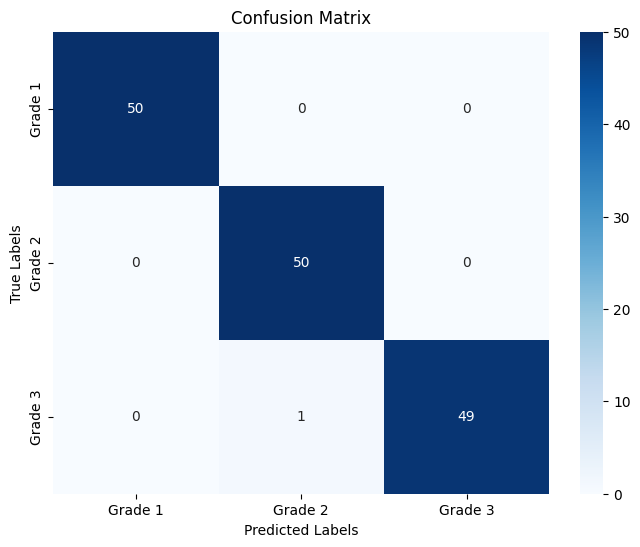

In [77]:
# Generate predictions on the test set
test_predictions = restnet_v1_model.predict(test_data)

# Convert the predicted probabilities to class labels
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(test_labels, test_predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

5/5 [==============================] - 14s 3s/step


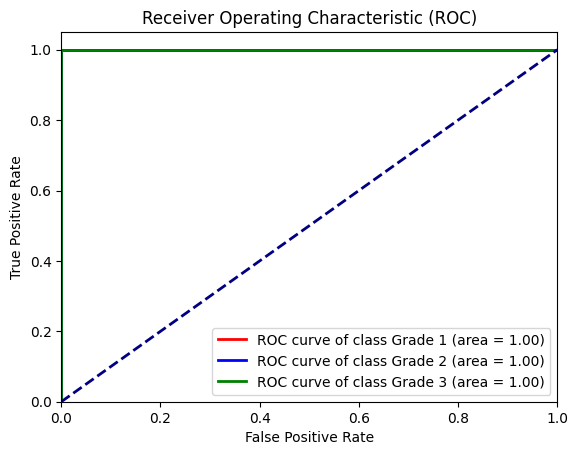

Macro-average ROC AUC: 1.0


In [79]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Convert labels to binary format
binary_labels = label_binarize(test_labels, classes=np.arange(len(class_names)))

# Compute the predicted probabilities for each class
class_probabilities = restnet_v1_model.predict(test_data)

# Compute the macro-average ROC AUC score
roc_auc = roc_auc_score(binary_labels, class_probabilities, average='macro')

# Plot the ROC curve for each class
plt.figure()
lw = 2
colors = ['red', 'blue', 'green']  # Add more colors if there are more classes
for i, color in zip(range(len(class_names)), colors):
    fpr, tpr, _ = roc_curve(binary_labels[:, i], class_probabilities[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc_class))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print the macro-average ROC AUC score
print("Macro-average ROC AUC:", roc_auc)

In [81]:
from sklearn.metrics import classification_report

# Make predictions on the test data
test_predictions = restnet_v1_model.predict(test_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Decode the predicted labels using the label encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# Generate the classification report
report = classification_report(test_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)

5/5 [==============================] - 14s 3s/step
Classification Report:
              precision    recall  f1-score   support

     Grade 1       1.00      1.00      1.00        50
     Grade 2       0.98      1.00      0.99        50
     Grade 3       1.00      0.98      0.99        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

